In [1180]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

tfd = tfp.distributions

In [1181]:
def generate_signal(noiseamp=0.05, hamp=5.0, f_sig=5.0):
    fsamp = 250
    Tobs = 1
    Tcoh = 0.5
    
    deltat = 1. / fsamp
    t = np.arange(0.0, Tobs, deltat)
    Nsample = len(t) # fsamp * total time
#     print(Nsample)
    noise = noiseamp * np.random.normal(0, scale = 1, size = Nsample)
    signal = hamp * np.sin(2 * np.pi * (f_sig * t))

    data = signal + noise
    
    return data

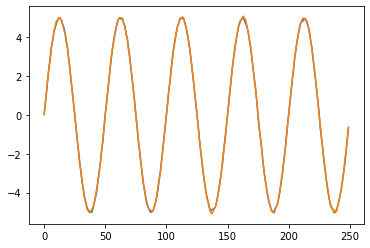

In [1182]:
y = generate_signal()

plt.plot(y)
plt.plot(generate_signal())

In [1183]:
N = 500

In [1184]:
f_s = np.linspace(8, 10, N)

In [1202]:
y_s = []
x_s = []
for f in f_s:
    y = generate_signal(noiseamp=0.01, hamp=5.0, f_sig=f)
    y_s.append(y)
    x_s.append([f])

x_s, y_s = np.array(x_s), np.array(y_s)

In [1203]:
from sklearn.model_selection import train_test_split

In [1204]:
# X_train, X_test, y_train, y_test = train_test_split(y_s,
#                                                     x_s,
#                                                     test_size=0.33,
#                                                     random_state=42)

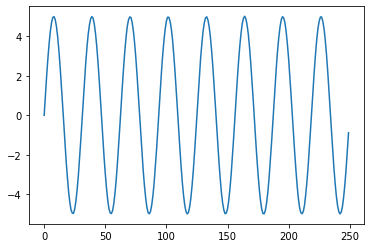

In [1205]:
plt.plot(y_s[1])

In [1206]:
# x_s = x_s.astype(tf.dtypes.float32)
# y_s = y_s.astype(tf.dtypes.float32)

In [1207]:
len(x_s), len(y_s)

(500, 500)

In [1208]:
x_s.shape, y_s.shape

((500, 1), (500, 250))

In [1209]:
y_s.shape, y_s

((500, 250),
 array([[ 1.43805340e-04,  1.00853035e+00,  1.96063921e+00, ...,
         -2.84388796e+00, -1.95016785e+00, -9.88666294e-01],
        [-1.93479222e-03,  1.00182307e+00,  1.96244155e+00, ...,
         -2.73404781e+00, -1.80783370e+00, -8.82209153e-01],
        [ 1.81305491e-02,  9.90218444e-01,  1.96033813e+00, ...,
         -2.61590008e+00, -1.74115301e+00, -7.69830317e-01],
        ...,
        [-1.08970355e-02,  1.24509348e+00,  2.40593859e+00, ...,
         -3.61172518e+00, -2.62791573e+00, -1.49481910e+00],
        [-1.35509666e-02,  1.22905317e+00,  2.40740275e+00, ...,
         -3.50777624e+00, -2.52598301e+00, -1.35800795e+00],
        [-1.58752414e-03,  1.24953162e+00,  2.41726900e+00, ...,
         -3.42163439e+00, -2.41163228e+00, -1.25388762e+00]]))

In [1210]:
split = 0.95

cutoff = int(split * len(x_s))

print(cutoff, len(x_s))

475 500


In [1211]:
x_s = tf.convert_to_tensor(x_s, dtype=tf.float32)
y_s = tf.convert_to_tensor(y_s, dtype=tf.float32)

In [1212]:
x_train, y_train = x_s[:cutoff], y_s[:cutoff]
x_test, y_test = x_s[cutoff:], y_s[cutoff:]

In [1213]:
batch_size = 32

In [1214]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(train_size).batch(batch_size)

In [1215]:
print(len(train_dataset), len(test_dataset))

15 1


In [1216]:
for a in train_dataset.enumerate():
    print(a[0].shape, a[1][0].shape, a[1][1].shape)
    break

() (32, 1) (32, 250)


In [1217]:
tf.config.run_functions_eagerly(True)

In [1218]:
params = dict()

params['z_dim'] = 8
params['n_modes'] = 1
params['n_channels'] = 1
params['ramp_start'] = 10
params['ramp_end'] = 20
params['y_normscale'] = 1.0

params['rand_pars'] = ['frequency']
params['inf_pars'] = ['frequency']


In [1219]:
def ramp_func(epoch,start,ramp_length, n_cycles):
    i = (epoch-start)/(2.0*ramp_length)
    print(epoch,i)
    if i<0:
        return 0.0
    if i>=n_cycles:
        return 1.0
    return min(1.0,2.0*np.remainder(i, 1.0))

optimizer = tf.keras.optimizers.Adam(1e-3)
initializer = tf.keras.initializers.GlorotUniform()

In [1220]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, x_dim, y_dim, n_channels, z_dim, n_modes, params):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.n_modes = n_modes
        self.x_modes = 1   # hardcoded for testing
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_channels = n_channels
        self.act = tf.keras.layers.LeakyReLU(alpha=0.1)
        self.params = params

        """
        # Add this to get rid of regularizer
        a2 = tf.keras.layers.Dense(2*self.z_dim*self.n_modes + self.n_modes)(a2)
        self.encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)
        print(self.encoder_r1.summary())
        """
        # the r1 encoder network
        r1_input_y = tf.keras.Input(shape=(self.y_dim, self.n_channels))
        a = tf.keras.layers.Conv1D(filters=8, kernel_size=32, strides=1, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(r1_input_y)
        a = tf.keras.layers.Conv1D(filters=8, kernel_size=16, strides=4, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(a)
        a = tf.keras.layers.Flatten()(a)
        a2 = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(a)
        a2 = tf.keras.layers.Dropout(.5)(a2)
        a2 = tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(a2)
        a2 = tf.keras.layers.Dropout(.5)(a2)
        a2 = tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(a2)
        a2 = tf.keras.layers.Dense(2*self.z_dim*self.n_modes + self.n_modes)(a2)
        self.encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)
#         print(self.encoder_r1.summary())
    
        
        # the q encoder network
        q_input_x = tf.keras.Input(shape=(self.x_dim))
        c = tf.keras.layers.Flatten()(q_input_x)
        d = tf.keras.layers.concatenate([a,c])        
        e = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(d)
        e = tf.keras.layers.Dropout(.5)(e)
        e = tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(e)
        e = tf.keras.layers.Dropout(.5)(e)
        e = tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(e)
        e = tf.keras.layers.Dense(2*self.z_dim)(e)
        self.encoder_q = tf.keras.Model(inputs=[r1_input_y, q_input_x], outputs=e)
#         print(self.encoder_q.summary())
        
        # the r2 decoder network
        r2_input_z = tf.keras.Input(shape=(self.z_dim))
        g = tf.keras.layers.Flatten()(r2_input_z)
        h = tf.keras.layers.concatenate([a,g])
        i = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(h)
        i = tf.keras.layers.Dropout(.5)(i)
        i = tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(i)
        i = tf.keras.layers.Dropout(.5)(i)
        i = tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation=self.act)(i)
        j = tf.keras.layers.Dense(2*self.x_dim*self.x_modes + self.x_modes)(i)
        self.decoder_r2 = tf.keras.Model(inputs=[r1_input_y, r2_input_z], outputs=j)
#         print(self.decoder_r2.summary())
    
    
    
    def get_encoders(self):
        return self.encoder_r1, self.encoder_q
    
    def encode_r1(self, y=None):
#         print("==")
#         print(y)
#         print(self.encoder_r1(y).shape)
#         print(self.encoder_r1(y))
#         print([self.z_dim*self.n_modes, self.z_dim*self.n_modes,self.n_modes])
#         print("==")
#         print(self.z_dim*self.n_modes + self.z_dim*self.n_modes + self.n_modes)
        
#         mean, logvar, weight = tf.split(self.encoder_r1(y), num_or_size_splits=[2, 4, 3], axis=1)
        mean, logvar, weight = tf.split(self.encoder_r1(y), num_or_size_splits=[self.z_dim*self.n_modes, self.z_dim*self.n_modes,self.n_modes], axis=1)
        
#         print(mean)
        return tf.reshape(mean,[-1,self.n_modes,self.z_dim]), tf.reshape(logvar,[-1,self.n_modes,self.z_dim]), tf.reshape(weight,[-1,self.n_modes])

    def encode_q(self, x=None, y=None):
        return tf.split(self.encoder_q([y,x]), num_or_size_splits=[self.z_dim, self.z_dim], axis=1)

    def decode_r2(self, y=None, z=None, apply_sigmoid=False):
        
#         print("AA", self.decoder_r2([y, z]).shape)
#         print("BB", [2 * self.x_dim * self.x_modes, self.x_modes])
        mean, logvar, weight = tf.split(self.decoder_r2([y, z]), num_or_size_splits=[self.x_dim*self.x_modes, self.x_dim*self.x_modes, self.x_modes], axis=1)
        return tf.reshape(mean,[-1,self.x_modes,self.x_dim]), tf.reshape(logvar,[-1,self.x_modes,self.x_dim]), tf.reshape(weight,[-1,self.x_modes])

In [1221]:
EPS = 1e-3
dist_mask = np.array([True])
not_dist_mask = np.array([True])

bounds = dict(a=0.0, b=10.0)

def compute_loss(model, x, y, ramp=1.0, noiseamp=1.0):
    
    old_old_x = x
    
    noiseamp = tf.cast(noiseamp, dtype=tf.float32)
    y_normscale = tf.cast(params['y_normscale'], dtype=tf.float32)
    y = tf.cast(y, dtype=tf.float32)
    x = tf.cast(x, dtype=tf.float32)
    
#     y = (y + noiseamp*tf.random.normal(shape=tf.shape(y), mean=0.0, stddev=1.0, dtype=tf.float32))
    
    
    # This is in the latent space z. z just from y.
    mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
    scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
    
    # Sample from the latent space. z just from y.
    gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
    
    # Latent space. z from x and y.
    mean_q, logvar_q = model.encode_q(x=x, y=y)
    scale_q = EPS + tf.sqrt(tf.exp(logvar_q))
    
    # Sample from the latent space. z from x and y.
    mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=mean_q,
                          scale_diag=scale_q)
    
    z_samp = mvn_q.sample()
    
    
    # Take the latent sample and y to reconstruct x. Pr[x | y, z]
    mean_r2, logvar_r2, logweight_r2 = model.decode_r2(z=z_samp, y=y)
    scale_r2 = EPS + tf.sqrt(tf.exp(logvar_r2))
    
    # This is a sample from x.
#     print(np.mean(mean_r2), end=", ")
    
    # Distribution for x. Pr[x | y, z]
    gm_r2 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r2),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r2,
            scale_diag=scale_r2))
    
    simple_cost_recon = -1.0*tf.reduce_mean(gm_r2.log_prob(old_old_x))

#     print(simple_cost_recon)
    
    selfent_q = -1.0*tf.reduce_mean(mvn_q.entropy())
    log_r1_q = gm_r1.log_prob(z_samp)   # evaluate the log prob of r1 at the q samples
    cost_KL = selfent_q - tf.reduce_mean(log_r1_q)
    
    
    return simple_cost_recon, cost_KL

In [1222]:
@tf.function
def train_step(model, x, y, optimizer, ramp=1.0):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    
    ramp = 1.0
    
    with tf.GradientTape() as tape:
        r_loss, kl_loss = compute_loss(model, x, y, ramp=ramp)
        loss = r_loss + ramp * kl_loss
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_metric(loss)
    return r_loss, kl_loss

In [1223]:
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [1224]:
x_s.shape[0], y_s.shape[1]

(500, 250)

In [1225]:
import random

In [1226]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

epochs = 25

# start the training loop
train_loss = np.zeros((epochs, 3))
val_loss = np.zeros((epochs, 3))
ramp_start = params['ramp_start']
ramp_length = params['ramp_end']


ramp_cycles = 1
KL_samples = []

model = CVAE(1, y_s.shape[1], params['n_channels'], params['z_dim'], params['n_modes'], params)

model.compile()

In [1227]:
for epoch in range(0, epochs + 1):

    train_loss_kl_q = 0.0
    train_loss_kl_r1 = 0.0
    start_time_train = time.time()
    
    ramp = tf.convert_to_tensor(ramp_func(epoch, ramp_start, ramp_length, ramp_cycles), dtype=tf.float32)
    
    for step, (x_batch_train, y_batch_train) in train_dataset.enumerate():
        
#         if step != 2:
#             continue
            
#         print(y_batch_train)
        temp_train_r_loss, temp_train_kl_loss = train_step(model, x_batch_train, y_batch_train, optimizer, ramp=ramp)
        train_loss[epoch-1,0] += temp_train_r_loss
        train_loss[epoch-1,1] += temp_train_kl_loss
        
    print(train_loss[epoch-1,0], train_loss[epoch-1,1], end=", ")
        
#     train_loss[epoch-1,2] = train_loss[epoch-1,0] + ramp * train_loss[epoch-1,1]
#     train_loss[epoch-1,:] /= float(step+1)
    
    
#     for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():             
#         mu_r1, z_r1, mu_q, z_q = gen_z_samples(model, x_batch_test, y_batch_test, nsamples=1000)

0 -0.25
128.86264038085938 23.26419448852539, 1 -0.225
57.75578689575195 -0.1103515625, 2 -0.2
53.01344299316406 2.315545082092285, 3 -0.175
47.97472381591797 -1.080575942993164, 4 -0.15
30.870563507080078 -0.6369752883911133, 5 -0.125
13.090324401855469 2.4419164657592773, 6 -0.1
6.3780598640441895 2.673807144165039, 7 -0.075
17.790454864501953 1.8011093139648438, 8 -0.05
34.974002838134766 1.9410104751586914, 9 -0.025
26.34690284729004 1.5463972091674805, 10 0.0
19.741147994995117 0.5518388748168945, 11 0.025
11.614360809326172 0.7421026229858398, 12 0.05
4.453554153442383 1.6093835830688477, 13 0.075
-1.8930402994155884 1.9576988220214844, 14 0.1
-7.30892276763916 0.25264644622802734, 15 0.125
-4.707611083984375 0.6664047241210938, 16 0.15
-6.87530517578125 -1.5265188217163086, 17 0.175
-11.193352699279785 0.7698535919189453, 18 0.2
148.58494567871094 0.1910238265991211, 19 0.225
124.38699340820312 1.1683549880981445, 20 0.25
52.87953186035156 2.7740116119384766, 21 0.275
43.7056541

In [1228]:
gen_samples(model, y_batch_train)

<tf.Tensor: shape=(27000, 1), dtype=float32, numpy=
array([[ 9.874783],
       [10.297418],
       [ 9.469968],
       ...,
       [ 9.213223],
       [ 9.993456],
       [10.039484]], dtype=float32)>

In [1229]:
# print(train_loss)

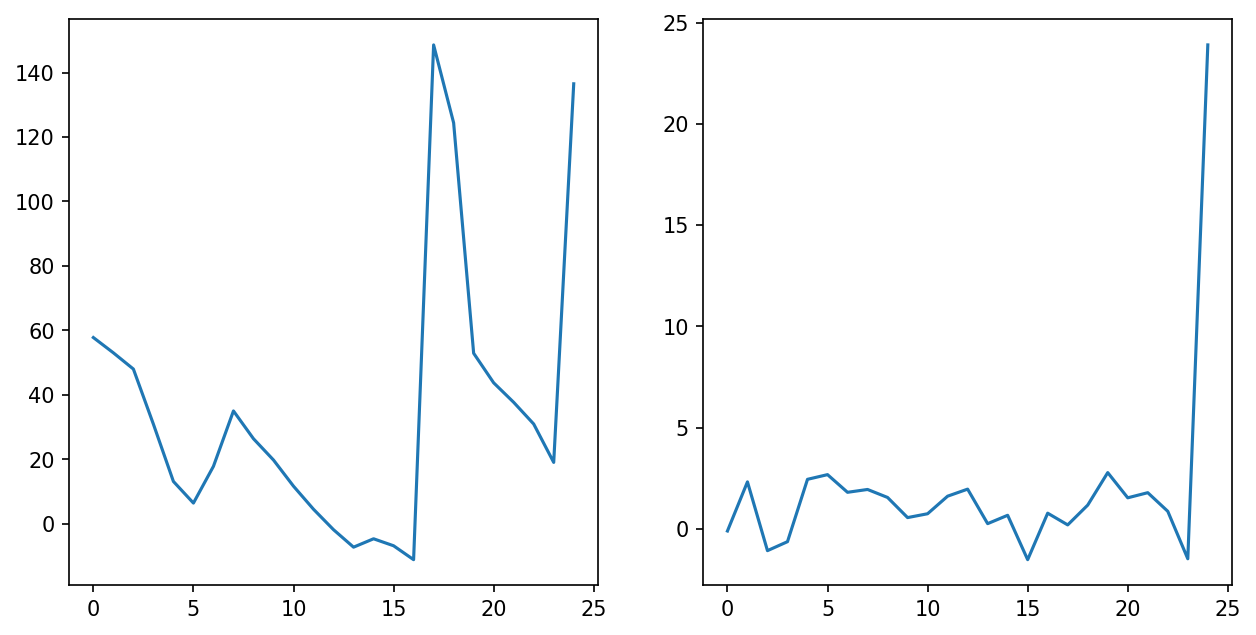

In [1230]:
plt.figure(figsize=(10, 5), dpi=150)

plt.subplot(121)
plt.plot(train_loss[:,0])

# plt.yscale('log')

plt.subplot(122)
plt.plot(train_loss[:,1])

# plt.yscale('log')

In [1231]:
def gen_z_samples(model, x, y, nsamples=1000):
    
    y = y / params['y_normscale']
    y = tf.tile(y,(nsamples,1))
    x = tf.tile(x,(nsamples,1))
    
    mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
    
    scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
    
    gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
    
    z_samp_r1 = gm_r1.sample()
    
    mean_q, logvar_q = model.encode_q(x=x,y=y)
    
    scale_q = EPS + tf.sqrt(tf.exp(logvar_q))
    mvn_q = tfp.distributions.MultivariateNormalDiag(
                          loc=mean_q,
                          scale_diag=scale_q)
    
    z_samp_q = mvn_q.sample()    
    
    return mean_r1, z_samp_r1, mean_q, z_samp_q

In [1232]:
def gen_samples(model, y, ramp=1.0, nsamples=1000, max_samples=1000):

    y = y
    y = tf.tile(y,(max_samples,1))
    
    samp_iterations = int(nsamples/max_samples)
    
    for i in range(samp_iterations):
        mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
        scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
        
        gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r1,
            scale_diag=scale_r1))
        
        z_samp = gm_r1.sample()
        
        mean_r2, logvar_r2, logweight_r2 = model.decode_r2(z=z_samp,y=y)
        scale_r2 = EPS + tf.sqrt(tf.exp(logvar_r2))
        
        gm_r2 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r2),
            components_distribution=tfd.MultivariateNormalDiag(
            loc=mean_r2,
            scale_diag=scale_r2))

        if i==0:
            x_sample = gm_r2.sample()
        else:
            x_sample = tf.concat([x_sample,gm_r2.sample()],axis=0)
    return x_sample


In [1233]:
def plot_posterior(samples, x_truth, epoch, idx, run='testing', all_other_samples=None):
    """
    plots the posteriors
    """

    # trim samples from outside the cube
    mask = []
    for s in samples:
        if (np.all(s>=0.0) and np.all(s<=1.0)):
            mask.append(True)
        else:
            mask.append(False)
            
    samples = tf.boolean_mask(samples,mask,axis=0)
    
    print('identified {} good samples'.format(samples.shape[0]))
    print(np.array(all_other_samples).shape)
    
    if samples.shape[0]<100:
        print('... Bad run, not doing posterior plotting.')
        return [-1.0] * len(params['samplers'][1:])

    # define general plotting arguments
    defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='tab:orange', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)

    # 1-d hist kwargs for normalisation
    hist_kwargs = dict(density=True,color='tab:red')
    hist_kwargs_other = dict(density=True,color='tab:blue')
    hist_kwargs_other2 = dict(density=True,color='tab:green')

    if all_other_samples is not None:
        KL_est = []
        for i, other_samples in enumerate(all_other_samples):
            true_post = np.zeros([other_samples.shape[0],bilby_ol_len])
            true_x = np.zeros(inf_ol_len)
            true_XS = np.zeros([samples.shape[0],inf_ol_len])
            ol_pars = []
            cnt = 0
            for inf_idx,bilby_idx in zip(inf_ol_idx,bilby_ol_idx):
                inf_par = params['inf_pars'][inf_idx]
                bilby_par = params['bilby_pars'][bilby_idx]
                true_XS[:,cnt] = (samples[:,inf_idx] * (bounds[inf_par+'_max'] - bounds[inf_par+'_min'])) + bounds[inf_par+'_min']
                true_post[:,cnt] = (other_samples[:,bilby_idx] * (bounds[bilby_par+'_max'] - bounds[bilby_par+'_min'])) + bounds[bilby_par + '_min']
                true_x[cnt] = (x_truth[inf_idx] * (bounds[inf_par+'_max'] - bounds[inf_par+'_min'])) + bounds[inf_par + '_min']
                ol_pars.append(inf_par)
                cnt += 1
            parnames = []
            for k_idx,k in enumerate(params['rand_pars']):
                if np.isin(k, ol_pars):
                    parnames.append(params['corner_labels'][k])

            # convert to RA
            true_XS = convert_hour_angle_to_ra(true_XS,params,ol_pars)
            #true_x = convert_hour_angle_to_ra(np.reshape(true_x,[1,true_XS.shape[1]]),params,ol_pars).flatten()
            old_true_post = true_post                 

            samples_file = '{}/posterior_samples_epoch_{}_event_{}_vit.txt'.format(run,epoch,idx)
            np.savetxt(samples_file,true_XS)

            # compute KL estimate
            idx1 = np.random.randint(0,true_XS.shape[0],2000)
            idx2 = np.random.randint(0,true_post.shape[0],2000)
            """
            try:
                current_KL = 0.5*(estimate(true_XS[idx1,:],true_post[idx2,:],n_jobs=4) + estimate(true_post[idx2,:],true_XS[idx1,:],n_jobs=4))
            except:
                current_KL = -1.0
                pass
            """
            current_KL = -1
            KL_est.append(current_KL)

            other_samples_file = '{}/posterior_samples_epoch_{}_event_{}_{}.txt'.format(run,epoch,idx,i)
            np.savetxt(other_samples_file,true_post)

            if i==0:
                figure = corner.corner(true_post, **defaults_kwargs,labels=parnames,
                           color='tab:blue',
                           show_titles=True, hist_kwargs=hist_kwargs_other)
            else:

                # compute KL estimate
                idx1 = np.random.randint(0,old_true_post.shape[0],2000)
                idx2 = np.random.randint(0,true_post.shape[0],2000)
                """
                try:
                    current_KL = 0.5*(estimate(old_true_post[idx1,:],true_post[idx2,:],n_jobs=4) + estimate(true_post[idx2,:],old_true_post[idx1,:],n_jobs=4))
                except:
                    current_KL = -1.0
                    pass
                """
                current_KL=-1
                KL_est.append(current_KL)

                corner.corner(true_post,**defaults_kwargs,
                           color='tab:green',
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs_other2)
        
        for j,KL in enumerate(KL_est):    
            plt.annotate('KL = {:.3f}'.format(KL),(0.2,0.95-j*0.02),xycoords='figure fraction',fontsize=18)

        corner.corner(true_XS,**defaults_kwargs,
                           color='tab:red',
                           fill_contours=True, truths=true_x,
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs)
        if epoch == 'pub_plot':
            print('Saved output to %s/comp_posterior_%s_event_%d.png' % (run,epoch,idx))
            plt.savefig('%s/comp_posterior_%s_event_%d.png' % (run,epoch,idx))
        else:
            print('Saved output to %s/comp_posterior_epoch_%d_event_%d.png' % (run,epoch,idx))
            plt.savefig('%s/comp_posterior_epoch_%d_event_%d.png' % (run,epoch,idx))
        plt.close()
        return KL_est

    else:
        # Get corner parnames to use in plotting labels
        parnames = []
        for k_idx,k in enumerate(params['rand_pars']):
            if np.isin(k, params['inf_pars']):
                parnames.append(params['corner_labels'][k])
        # un-normalise full inference parameters
        full_true_x = np.zeros(len(params['inf_pars']))
        new_samples = np.zeros([samples.shape[0],len(params['inf_pars'])])
        for inf_par_idx,inf_par in enumerate(params['inf_pars']):
            new_samples[:,inf_par_idx] = (samples[:,inf_par_idx] * (bounds[inf_par+'_max'] - bounds[inf_par+'_min'])) + bounds[inf_par+'_min']
            full_true_x[inf_par_idx] = (x_truth[inf_par_idx] * (bounds[inf_par+'_max'] - bounds[inf_par+'_min'])) + bounds[inf_par + '_min']
        new_samples = convert_hour_angle_to_ra(new_samples,params,params['inf_pars'])
        full_true_x = convert_hour_angle_to_ra(np.reshape(full_true_x,[1,samples.shape[1]]),params,params['inf_pars']).flatten()       

        figure = corner.corner(new_samples,**defaults_kwargs,labels=parnames,
                           color='tab:red',
                           fill_contours=True, truths=full_true_x,
                           show_titles=True, hist_kwargs=hist_kwargs)
        if epoch == 'pub_plot':
            plt.savefig('%s/full_posterior_%s_event_%d.png' % (run,epoch,idx))
        else:
            plt.savefig('%s/full_posterior_epoch_%d_event_%d.png' % (run,epoch,idx))
        plt.close()
    return -1.0


In [1234]:
def plot_latent(mu_r1, z_r1, mu_q, z_q, epoch, idx, run='testing'):

    # define general plotting arguments
    defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='tab:orange', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)

    # 1-d hist kwargs for normalisation
    hist_kwargs = dict(density=True,color='tab:red')
    hist_kwargs_other = dict(density=True,color='tab:blue')

    
    figure = corner.corner(np.array(z_q), **defaults_kwargs,
                           color='tab:blue',
                           show_titles=True, hist_kwargs=hist_kwargs_other)
    corner.corner(np.array(z_r1),**defaults_kwargs,
                           color='tab:red',
                           fill_contours=True,
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs)
    # Extract the axes
    z_dim = z_r1.shape[1]
    axes = np.array(figure.axes).reshape((z_dim, z_dim))

    # Loop over the histograms
    for yi in range(z_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.plot(mu_r1[0,:,xi], mu_r1[0,:,yi], "sr")
            ax.plot(mu_q[0,xi], mu_q[0,yi], "sb")
    if epoch == 'pub_plot':
        plt.savefig('%s/latent_%s_event_%d.png' % (run,epoch,idx))
    else:
        plt.savefig('%s/latent_epoch_%d_event_%d.png' % (run,epoch,idx), facecolor="white", transparent=False)
    plt.close()

In [1235]:
import corner

In [1236]:
plot_dir = "./"
params['n_samples'] = 1000

run = plot_dir

In [1237]:
# for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():             
#     mu_r1, z_r1, mu_q, z_q = gen_z_samples(model, x_batch_test, y_batch_test, nsamples=1000)
#     plot_latent(mu_r1,z_r1,mu_q,z_q,epoch,step,run=plot_dir)
#     start_time_test = time.time()
#     samples = gen_samples(model, y_batch_test, ramp=ramp, nsamples=params['n_samples'])
#     end_time_test = time.time()
#     if np.any(np.isnan(samples)):
#         print('Epoch: {}, found nans in samples. Not making plots'.format(epoch))
#         for k,s in enumerate(samples):
#             if np.any(np.isnan(s)):
#                 print(k,s)
#         KL_est = [-1,-1,-1]
#     else:
#         print('Epoch: {}, run {} Testing time elapsed for {} samples: {}'.format(epoch,run,params['n_samples'],end_time_test - start_time_test))
#         KL_est = plot_posterior(samples,x_batch_test[0,:],epoch,step,run=plot_dir)
#         _ = plot_posterior(samples,x_batch_test[0,:],epoch,step,run=plot_dir)

In [1238]:
# old_d = bounds['a'] + tf.boolean_mask(x, dist_mask, axis=1)*(bounds['b'] - bounds['a'])
#     new_x = tf.random.uniform(shape=tf.shape(old_d), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
# #     new_d = bounds['a'] + new_x*(bounds['b'] - bounds['a'])
# #     x = tf.gather(tf.concat([tf.reshape(tf.boolean_mask(x, not_dist_mask,axis=1),[-1,tf.shape(x)[1]-1]), 
# #                              tf.reshape(new_x,[-1,1])],axis=1),tf.constant(idx_dist_mask),axis=1)
    
# #     x = tf.gather(tf.concat([tf.reshape(x,[-1,tf.shape(x)[1]-1]), tf.reshape(new_x,[-1,1])],axis=1),tf.constant([1]),axis=1)

#     x = tf.gather(tf.concat([tf.reshape(tf.boolean_mask(x, not_dist_mask,axis=1), [-1, tf.shape(x)[1] - 1]), 
#                   tf.reshape(new_x, [-1, 1])], axis=1), 
#                   tf.constant([1]), axis=1)

In [1239]:
# for step, (x_batch_train, y_batch_train) in train_dataset.enumerate():
# #         print(x_batch_train, y_batch_train, optimizer)
#         x = x_batch_train
#         y = y_batch_train
        
#         old_d = bounds['a'] + tf.boolean_mask(x, dist_mask, axis=1)*(bounds['b'] - bounds['a'])
#         new_x = tf.random.uniform(shape=tf.shape(old_d), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
        
        
#         old_d = bounds['a'] + tf.boolean_mask(x, dist_mask, axis=1)*(bounds['b'] - bounds['a'])
#         new_x = tf.random.uniform(shape=tf.shape(old_d), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
#         new_d = bounds['a'] + new_x*(bounds['b'] - bounds['a'])
#         x = tf.gather(tf.concat([tf.reshape(tf.boolean_mask(x, not_dist_mask,axis=1), [-1, tf.shape(x)[1]]), tf.reshape(new_x,[-1, 1])], axis=1), tf.constant(1), axis=1)
        
# #         print("Ha")
# #         print(x.shape)
# #         y = tf.reshape(y, (8, 500, 1))

# #         y = tf.expand_dims(y, axis=2)
#         abc = tf.expand_dims(old_d / new_d, axis=1)
        
# #         print(abc.shape)
# #         print("AAA")
# #         print(old_d.shape, new_d.shape)
#         dist_scale = tf.tile(old_d / new_d, (1, tf.shape(y)[1]))

#         norm = tf.random.normal(shape=tf.shape(y), mean=0.0, stddev=1.0, dtype=tf.float32)
        
# #         print(y.shape, dist_scale.shape, tf.shape(dist_scale))
        
#         noiseamp = 1.0
#         y_normscale = 1.0
#         # add noise and randomise distance again
# #         y = (y * dist_scale + noiseamp * tf.random.normal(shape=tf.shape(dist_scale), mean=0.0, stddev=1.0, dtype=tf.float32)) / y_normscale

#         mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
#         scale_r1 = EPS + tf.sqrt(tf.exp(logvar_r1))
        
#         print(y.shape)
#         print(y)
        
#         abc = model.encoder_r1(y)
#         print("ABC")
#         print(abc)
#         print(mean_r1.shape, scale_r1.shape, y.shape, logvar_r1.shape)
# #         print(mean_r1)
#         pqr = model.encode_r1(y)

#         print(pqr)
    
#         gm_r1 = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1),
#                 components_distribution=tfd.MultivariateNormalDiag(
#                 loc=mean_r1,
#                 scale_diag=scale_r1))
#         mean_q, logvar_q = model.encode_q(x=x,y=y)
#         scale_q = EPS + tf.sqrt(tf.exp(logvar_q))
#         mvn_q = tfp.distributions.MultivariateNormalDiag(
#                               loc=mean_q,
#                               scale_diag=scale_q)
#         #mvn_q = tfd.Normal(loc=mean_q,scale=scale_q)
#         z_samp = mvn_q.sample()
        
# #         print(z_samp.shape)


        

#         break
    
    
    
# # # x = tf.gather(tf.concat([tf.reshape(tf.boolean_mask(x,not_dist_mask,axis=1),[-1, tf.shape(x)[1]-1]), tf.reshape(new_x,[-1,1])],axis=1),tf.constant(idx_dist_mask),axis=1)
    

In [1240]:
# encoder_r, encoder_q = model.get_encoders()

In [1241]:
# encoder_r, encoder_q = model.encoder_r1, model.encoder_q

In [1242]:
# # r1_input_y = tf.keras.Input(shape=(y_s.shape[1], 1))
# # a = tf.keras.layers.Conv1D(filters=8, kernel_size=32, strides=1, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation=tf.keras.layers.LeakyReLU(alpha=0.3))(r1_input_y)
# # a = tf.keras.layers.Conv1D(filters=8, kernel_size=16, strides=4, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a)
# # a = tf.keras.layers.Flatten()(a)
# # a2 = tf.keras.layers.Dense(8, kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a)
# # encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)

# y_dim = 500
# n_channels = 1
# z_dim = 4
# n_modes = 1

# r1_input_y = tf.keras.Input(shape=(y_dim, n_channels))
# a = tf.keras.layers.Conv1D(filters=8, kernel_size=32, strides=1, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation=tf.keras.layers.LeakyReLU(alpha=0.3))(r1_input_y)
# a = tf.keras.layers.Conv1D(filters=8, kernel_size=16, strides=4, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a)
# a = tf.keras.layers.Flatten()(a)
# a2 = tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a)
# a2 = tf.keras.layers.Dropout(.5)(a2)
# a2 = tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a2)
# a2 = tf.keras.layers.Dropout(.5)(a2)
# a2 = tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializer, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(a2)
# a2 = tf.keras.layers.Dense(2*z_dim*n_modes + n_modes, kernel_initializer=initializer)(a2)
# encoder_r1 = tf.keras.Model(inputs=r1_input_y, outputs=a2)




# for step, (x_batch_train, y_batch_train) in train_dataset.enumerate():
# #     print(x_batch_train, y_batch_train, optimizer)
#     x = x_batch_train
#     y = y_batch_train
    
    
#     e = encoder_r1(y)
    
#     print(e.shape)
# #     print(e)
#     mean, logvar, weight = tf.split(e, num_or_size_splits=[4, 4, 1], axis=1)
    
# #     print(mean)


# #     tf.reshape(mean, [-1, 1, 4]), tf.reshape(logvar,[-1,self.n_modes,self.z_dim]), tf.reshape(weight,[-1,self.n_modes])

#     a = tf.reshape(mean, [-1, 1, 4])
#     print(a)
    
# #     old_old_x = x
# #     # Recasting some things to float32
# #     noiseamp = tf.cast(noiseamp, dtype=tf.float32)
# #     y_normscale = tf.cast(params['y_normscale'], dtype=tf.float32)
# #     y = tf.cast(y, dtype=tf.float32)
# #     x = tf.cast(x, dtype=tf.float32)


# #     # randomise distance    
# #     old_d = bounds['a'] + tf.boolean_mask(x, dist_mask, axis=1)*(bounds['b'] - bounds['a'])
# #     new_x = tf.random.uniform(shape=tf.shape(old_d), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
# #     new_d = bounds['a'] + new_x*(bounds['b'] - bounds['a'])
# #     x = tf.gather(tf.concat([tf.reshape(tf.boolean_mask(x, not_dist_mask,axis=1), [-1, tf.shape(x)[1]]), tf.reshape(new_x,[-1, 1])], axis=1), tf.constant(1), axis=1)

# #     dist_scale = tf.tile(old_d / new_d, (1, tf.shape(y)[1]))


# #     # add noise and randomise distance again
# #     y = (y * dist_scale + noiseamp*tf.random.normal(shape=tf.shape(y), mean=0.0, stddev=1.0, dtype=tf.float32)) / y_normscale
    
    
    
# # #     mean_r1, logvar_r1, logweight_r1 = model.encode_r1(y=y)
    
    
# #     mean, logvar, weight = tf.split(model.encoder_r1(y), num_or_size_splits=[model.z_dim*model.n_modes, model.z_dim*model.n_modes,model.n_modes], axis=1)
    
    
# #     print(mean)
    
# #     break

In [1243]:
def plot_latent(mu_r1, z_r1, mu_q, z_q, epoch, idx, run='testing'):

    # define general plotting arguments
    defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='tab:orange', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)

    # 1-d hist kwargs for normalisation
    hist_kwargs = dict(density=True,color='tab:red')
    hist_kwargs_other = dict(density=True,color='tab:blue')

    
    figure = corner.corner(np.array(z_q), **defaults_kwargs,
                           color='tab:blue',
                           show_titles=True, hist_kwargs=hist_kwargs_other)
    corner.corner(np.array(z_r1),**defaults_kwargs,
                           color='tab:red',
                           fill_contours=True,
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs)
    # Extract the axes
    z_dim = z_r1.shape[1]
    axes = np.array(figure.axes).reshape((z_dim, z_dim))

    # Loop over the histograms
    for yi in range(z_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.plot(mu_r1[0,:,xi], mu_r1[0,:,yi], "sr")
            ax.plot(mu_q[0,xi], mu_q[0,yi], "sb")
    if epoch == 'pub_plot':
        plt.savefig('%s/latent_%s_event_%d.png' % (run,epoch,idx))
    else:
        plt.savefig('%s/latent_epoch_%d_event_%d.png' % (run,epoch,idx))
    plt.close()

In [1244]:
x = tf.Variable(tf.random.uniform([5, 30], -1, 1))

In [1245]:
len(test_dataset)

1

In [1246]:
x.shape
params['n_samples'] = 1000

In [1247]:
params['corner_labels'] = {'frequency': 'freq'}


bounds = {'frequency_min': 0, 'frequency_max': 10}

defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='#4682b4', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)


hist_kwargs = dict(density=True,color='tab:red')
hist_kwargs_other = dict(density=True,color='tab:blue')

Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
9.483145


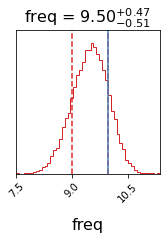

In [1248]:
width = int(np.sqrt(len(x_batch_test)))
height = int(np.sqrt(len(x_batch_test)))




for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():

    samples = gen_samples(model, y_batch_test, ramp=ramp, nsamples=params['n_samples'])

    print('Epoch: {}, run {} Testing time elapsed for {} samples: {}'.format(epoch,run,params['n_samples'], end_time_test - start_time_test))

    
    #     KL_est = plot_posterior(samples,x_batch_test[0,:],epoch,step,run=plot_dir)
#     _ = plot_posterior(samples,x_batch_test[0,:],epoch,step,run=plot_dir)
    
    x_truth = x_batch_test
    print(np.mean(samples))

    # Get corner parnames to use in plotting labels
    parnames = []
    for k_idx,k in enumerate(params['rand_pars']):
        if np.isin(k, params['inf_pars']):
            parnames.append(params['corner_labels'][k])

    full_true_x = np.zeros(len(params['inf_pars']))
    new_samples = np.zeros([samples.shape[0], len(params['inf_pars'])])


    for inf_par_idx,inf_par in enumerate(params['inf_pars']):
        new_samples[:,inf_par_idx] = samples[:,inf_par_idx]
        full_true_x[inf_par_idx] = x_truth[inf_par_idx]
    
#     plt.subplot(width, height, step + 1)
    figure = corner.corner(new_samples,**defaults_kwargs,labels=parnames,
                       color='tab:red',
                       fill_contours=True, truths=full_true_x,
                       show_titles=True, hist_kwargs=hist_kwargs)
    
#     break

In [1249]:
defaults_kwargs = dict(
                    bins=50, smooth=0.9, label_kwargs=dict(fontsize=16),
                    title_kwargs=dict(fontsize=16),
                    truth_color='tab:orange', quantiles=[0.16, 0.84],
                    levels=(0.68,0.90,0.95), density=True,
                    plot_density=False, plot_datapoints=True,
                    max_n_ticks=3)

# 1-d hist kwargs for normalisation
hist_kwargs = dict(density=True,color='tab:red')
hist_kwargs_other = dict(density=True,color='tab:blue')

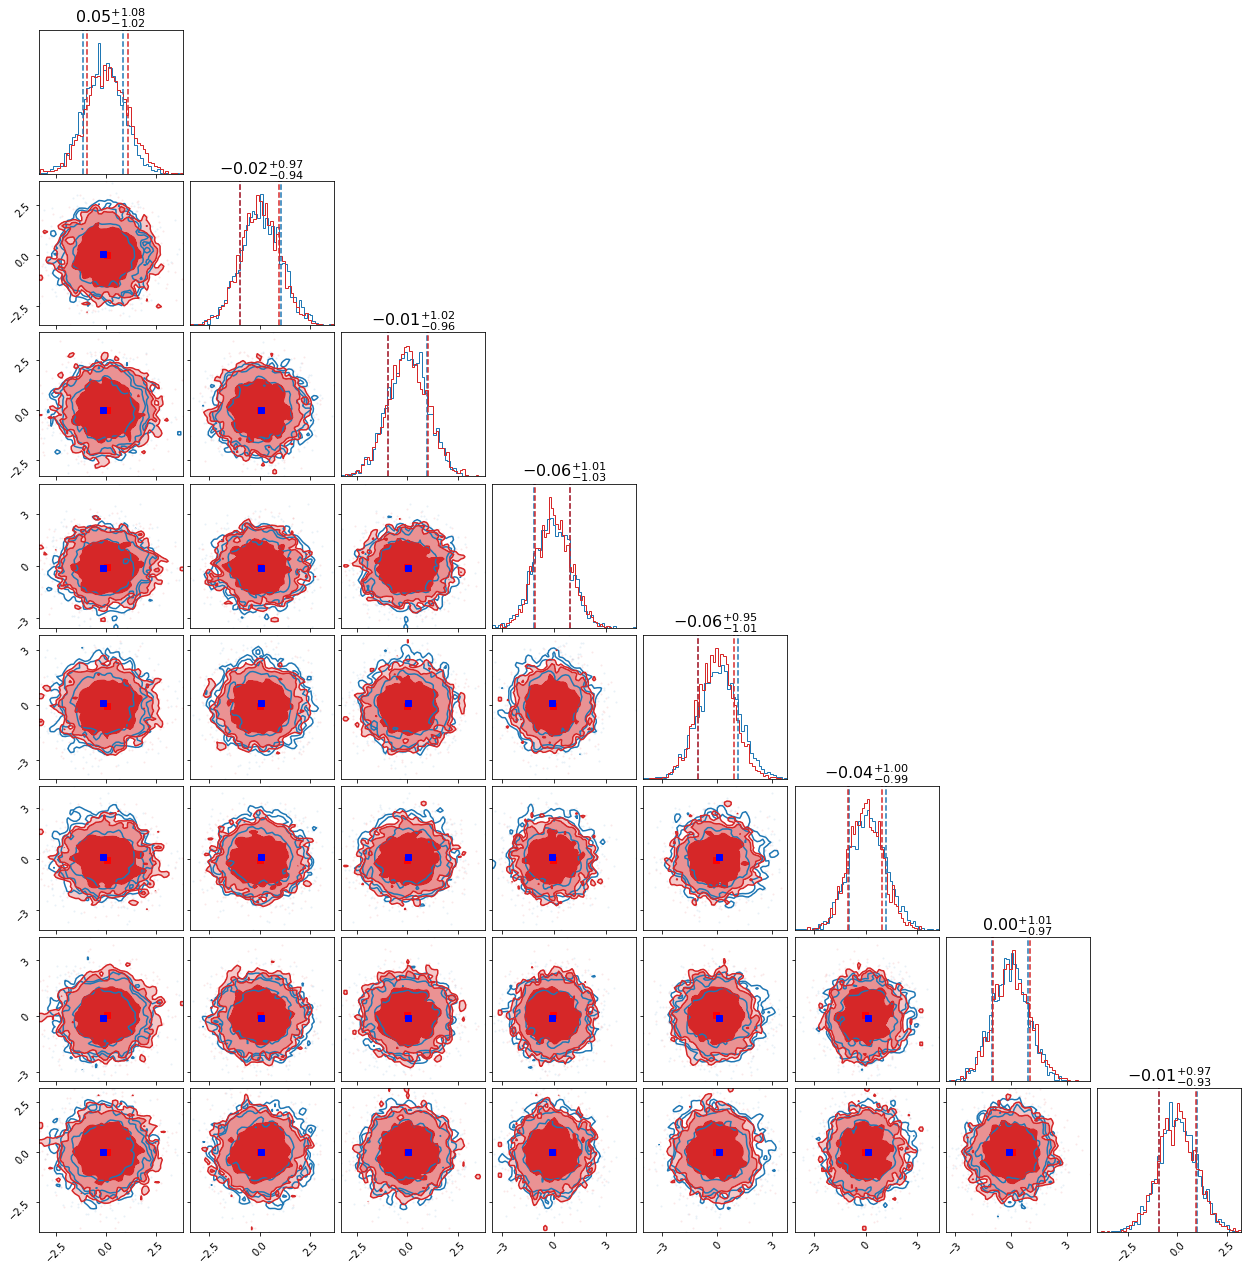

In [1250]:

for step, (x_batch_test, y_batch_test) in test_dataset.enumerate():

    mu_r1, z_r1, mu_q, z_q = gen_z_samples(model, x_batch_test, y_batch_test, nsamples=100)
#     plot_latent(mu_r1,z_r1,mu_q,z_q,epoch,step,run=plot_dir)

    figure = corner.corner(np.array(z_q), **defaults_kwargs,
                           color='tab:blue',
                           show_titles=True, hist_kwargs=hist_kwargs_other)
    corner.corner(np.array(z_r1),**defaults_kwargs,
                           color='tab:red',
                           fill_contours=True,
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs)
    # Extract the axes
    z_dim = z_r1.shape[1]
    axes = np.array(figure.axes).reshape((z_dim, z_dim))

    # Loop over the histograms
    for yi in range(z_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.plot(mu_r1[0,:,xi], mu_r1[0,:,yi], "sr")
            ax.plot(mu_q[0,xi], mu_q[0,yi], "sb")
            
    plt.savefig("latent.pdf")
    
    break

In [1272]:
N_test = 500

f_s = np.linspace(2, 4, N_test)

y_s = []
x_s = []
for f in f_s:
    y = generate_signal(noiseamp=0.05, hamp=5.0, f_sig=f)
    y_s.append(y)
    x_s.append([f])

x_s, y_s = np.array(x_s), np.array(y_s)


x_s = tf.convert_to_tensor(x_s, dtype=tf.float32)
y_s = tf.convert_to_tensor(y_s, dtype=tf.float32)

In [1273]:
test_dataset_different_freq = tf.data.Dataset.from_tensor_slices((x_s, y_s)).shuffle(N_test).batch(batch_size)

In [1271]:
# list(test_dataset_different_freq)[0][0].numpy

In [1276]:
np.mean(list(test_dataset_different_freq)[0][0])

2.9748247

Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.980779
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
9.001957
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.869261
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.87329
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
9.018748
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.970156
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
9.040582
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.90442
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.901668
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.859358
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.8021914958953857
8.949875
Epoch: 25, run ./ Testing time elapsed for 1000 samples: 1.80219149

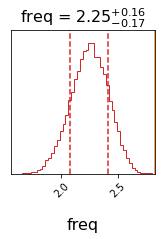

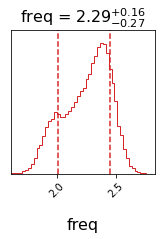

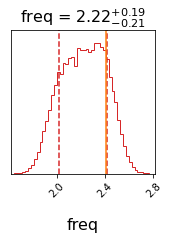

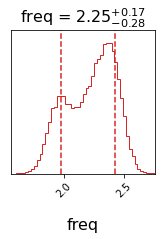

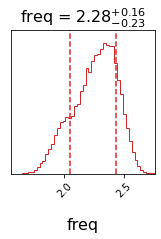

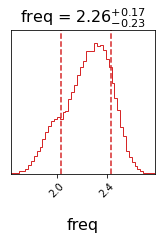

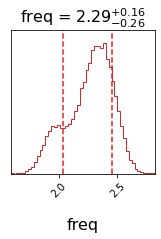

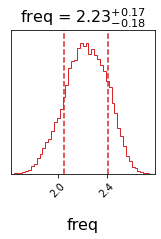

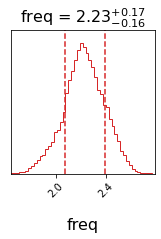

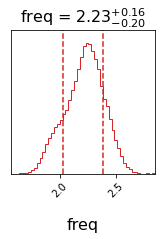

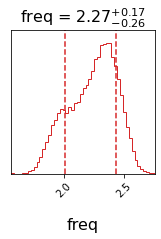

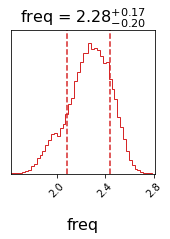

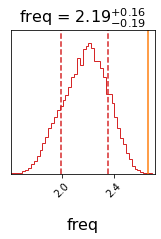

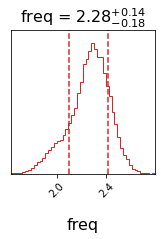

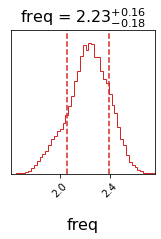

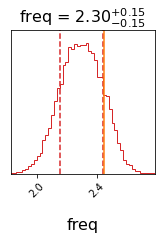

In [1280]:
for step, (x_batch_test, y_batch_test) in test_dataset_different_freq.enumerate():

    samples = gen_samples(model, y_batch_test, ramp=ramp, nsamples=params['n_samples'])

    print('Epoch: {}, run {} Testing time elapsed for {} samples: {}'.format(epoch,run,params['n_samples'], end_time_test - start_time_test))

    print(np.mean(samples))
    extra_factor = 0.25
    
    x_truth = x_batch_test
    
    parnames = []
    for k_idx,k in enumerate(params['rand_pars']):
        if np.isin(k, params['inf_pars']):
            parnames.append(params['corner_labels'][k])

    full_true_x = np.zeros(len(params['inf_pars']))
    new_samples = np.zeros([samples.shape[0], len(params['inf_pars'])])


    for inf_par_idx,inf_par in enumerate(params['inf_pars']):
        new_samples[:,inf_par_idx] = extra_factor * samples[:,inf_par_idx]
        full_true_x[inf_par_idx] = x_truth[inf_par_idx]
    
    figure = corner.corner(new_samples,**defaults_kwargs,labels=parnames,
                       color='tab:red',
                       fill_contours=True, truths=full_true_x,
                       show_titles=True, hist_kwargs=hist_kwargs)

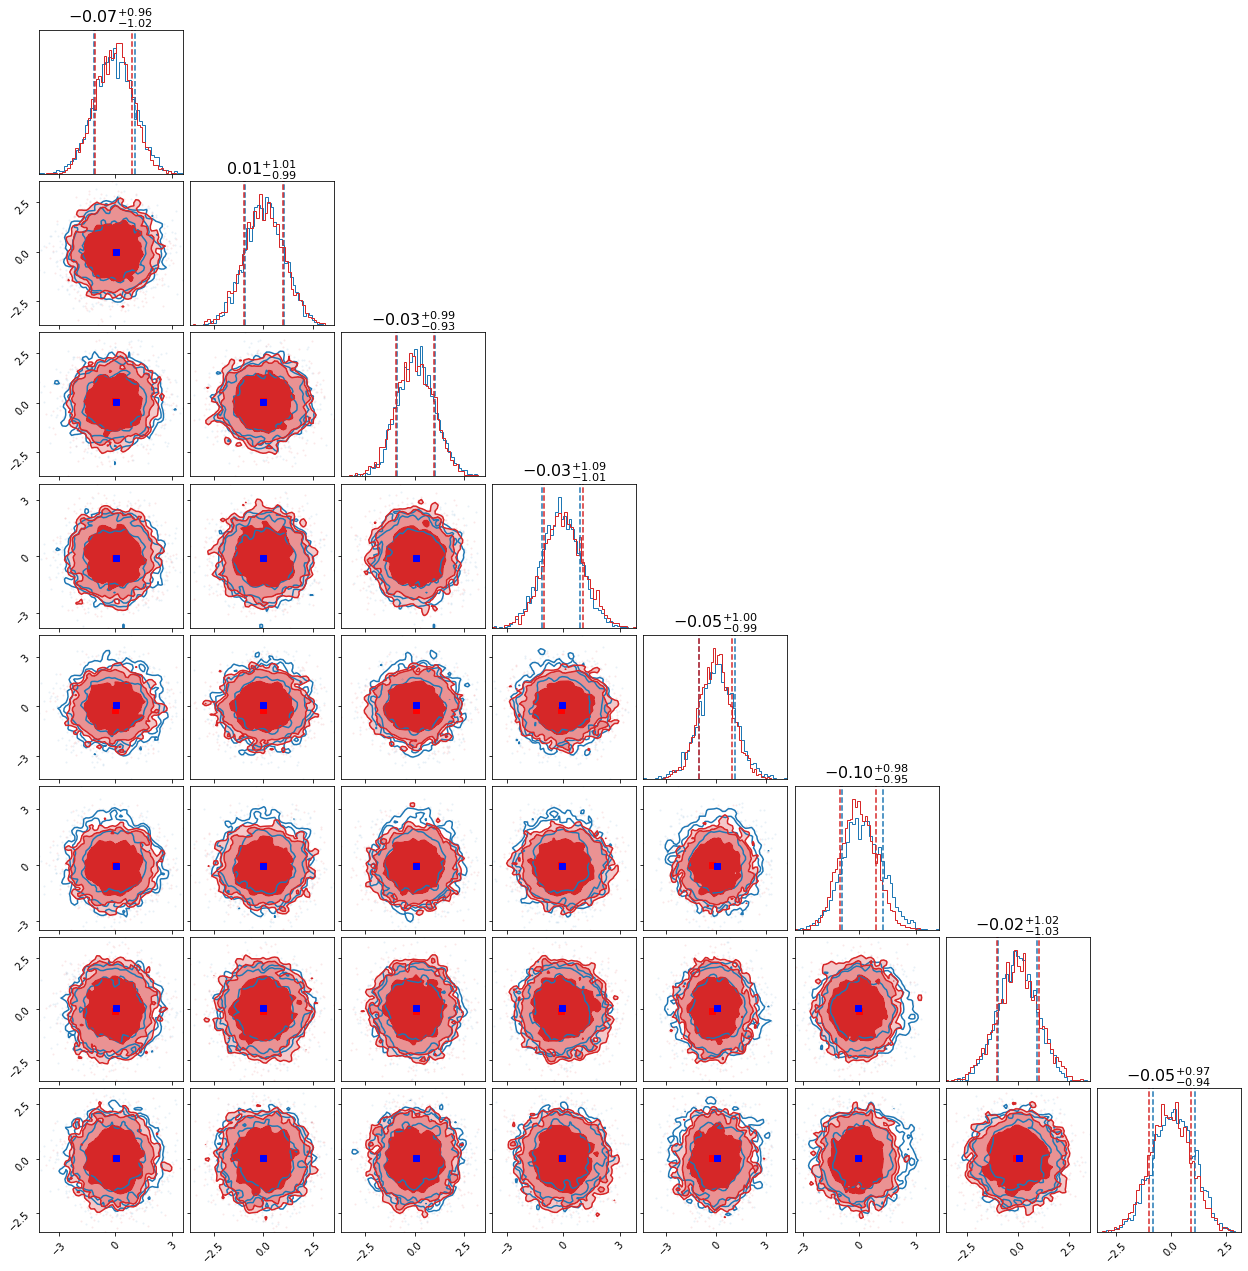

In [1256]:

for step, (x_batch_test, y_batch_test) in test_dataset_different_freq.enumerate():

    mu_r1, z_r1, mu_q, z_q = gen_z_samples(model, x_batch_test, y_batch_test, nsamples=100)
#     plot_latent(mu_r1,z_r1,mu_q,z_q,epoch,step,run=plot_dir)

    figure = corner.corner(np.array(z_q), **defaults_kwargs,
                           color='tab:blue',
                           show_titles=True, hist_kwargs=hist_kwargs_other)
    corner.corner(np.array(z_r1),**defaults_kwargs,
                           color='tab:red',
                           fill_contours=True,
                           show_titles=True, fig=figure, hist_kwargs=hist_kwargs)
    # Extract the axes
    z_dim = z_r1.shape[1]
    axes = np.array(figure.axes).reshape((z_dim, z_dim))

    # Loop over the histograms
    for yi in range(z_dim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.plot(mu_r1[0,:,xi], mu_r1[0,:,yi], "sr")
            ax.plot(mu_q[0,xi], mu_q[0,yi], "sb")
            
    plt.savefig("latent_test.pdf")
    
    break